**MNIST using FastAI**

Using only Lesson 1 from fast.ai's wonderful practical course on Deep Learning, it is definitely possible to build a really well functioning digit recognizer for Kaggle's playground competition. In fact, this model gets around 98.5% accuracy. For a first try, I have to say, that's not bad at all. 

Importing the necessary libraries:

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from pathlib import Path
# Any results you write to the current directory are saved as output.

from fastai.vision import *
from fastai.metrics import error_rate

from PIL import Image

/kaggle/input/resnet50/resnet50.pth
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [4]:
#Checking if CUDA is available
print(torch.cuda.is_available())

True


In [5]:
inputs=Path("../input/digit-recognizer")
os.listdir(inputs)

['sample_submission.csv', 'train.csv', 'test.csv']

Reading the train and test datasets using Pandas:

In [6]:
train=pd.read_csv(inputs/"train.csv")
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test=pd.read_csv(inputs/"test.csv")

tfms is just a parameter used later during training, which is initalized here. tr and te are paths to be used.

In [8]:
tfms = get_transforms(do_flip=False)
tr=Path("../train")
te=Path("../test")

We have to try and get the dataset into a folder format, from the existing format, which will make it easier to use fastai's functions.

Currently, it is not even an image, just a 0s and 1s, as seen from the training set. Using the functions below, we can convert them into images:

In [9]:
for index in range(10):
    try:
        os.makedirs(tr/str(index))
    except:
        pass

In [10]:
sorted(os.listdir(tr))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [11]:
try:
    os.makedirs(te)
except:
    pass


In [12]:
for index, row in train.iterrows():
    
    label,digit = row[0], row[1:]
    
    filepath = tr/str(label)
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)
    
    

In [13]:
for index, digit in test.iterrows():

    filepath = te
    filename = f"{index}.jpg"
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(filepath/filename)

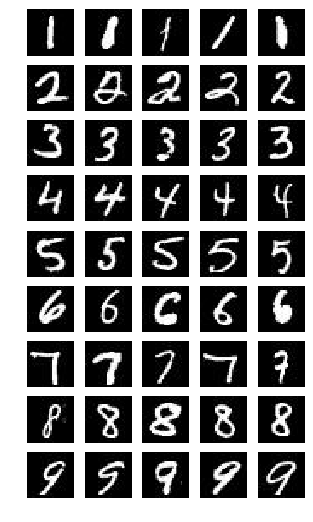

In [14]:
def displayRandomImagesFromEveryFolder(directory=tr, samplesPerDigit=5):

    fig = plt.figure(figsize=(5,10))
    
    for rowIndex in range(1, 10):
        subdirectory = str(rowIndex)
        path = directory/subdirectory
        images = os.listdir(path)
        for sampleIndex in range(1,samplesPerDigit+1):
            randomNumber = random.randint(0, len(images)-1)
            image = Image.open(path/images[randomNumber])
            ax = fig.add_subplot(10, 5, samplesPerDigit*rowIndex + sampleIndex)
            ax.axis("off")
            
            plt.imshow(image, cmap='gray')
            
    
    plt.show()
    
displayRandomImagesFromEveryFolder()

The dataset has been converted into images!

We can move on to getting the data from folders, and seperating them into training and validation sets. Also normalization is very important to make sure all values lie between 0 and 1.

In [15]:
data = ImageDataBunch.from_folder(path=tr,test=te,ds_tfms=tfms, valid_pct=0.2,bs=32,size=24).normalize(imagenet_stats)

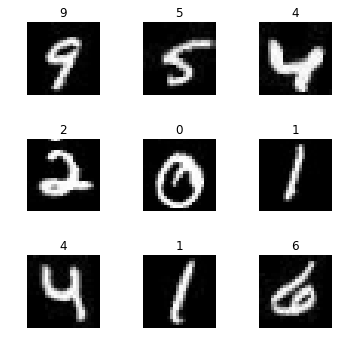

In [16]:
data.show_batch(rows=3 ,figsize=(5,5))

The data has been successfully extracted from the folders. 

We can also check what classes exist:

In [17]:
print(data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Now for the actual training part. 
fastai makes it very easy to use Resnet50, a pretrained image classifiying model. To use it in Kaggle, we need just two addiitional lines of code. 
Then, we can use the cnn_learner function, and create a Convolutional Neural Network. 

In [18]:
!mkdir -p /tmp/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50.pth /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [20]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir = Path('../kaggle/input/ResNet-50'), callback_fns=ShowGraph)

Now, to see what the ideal learning rates are:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


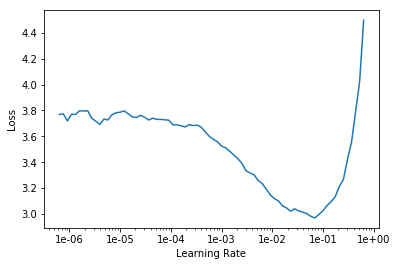

In [24]:
learn.lr_find()
learn.recorder.plot()

We can clearly see that the learning rate is most effective at 1e-01, but let's try without a predefined learning rate:

epoch,train_loss,valid_loss,accuracy,time
0,1.074175,0.626494,0.795238,01:28
1,0.495254,0.226878,0.930952,01:27
2,0.271508,0.131400,0.959762,01:27
3,0.237339,0.095737,0.970476,01:27
4,0.196955,0.091395,0.972619,01:27


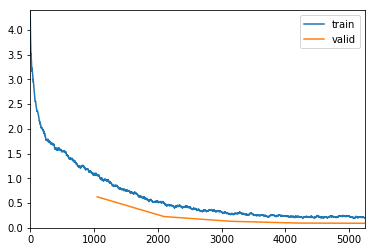

In [25]:
learn.fit_one_cycle(5)

97% accuracy, not bad at all.

Saving this model:

In [28]:
learn.save("501")

Now, let's try with the optimal learning rates:

epoch,train_loss,valid_loss,accuracy,time
0,1.532120,27.403965,0.903690,01:37
1,3.340269,418.381775,0.947143,01:35
2,0.916732,58.056259,0.970714,01:35
3,0.161964,0.079115,0.990000,01:36
4,0.064190,0.033313,0.992619,01:36


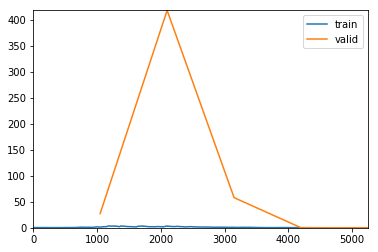

In [29]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=slice(1e-3,1e-1))

99.2% accuracy in just 5 cycles? Wow. 

In [30]:
learn.save("502")

We can interpret our results as well:

In [31]:
interp=ClassificationInterpretation.from_learner(learn)

In [34]:
interp.most_confused(min_val=3)

[('4', '9', 7),
 ('9', '4', 5),
 ('0', '6', 4),
 ('2', '8', 4),
 ('5', '3', 4),
 ('1', '7', 3),
 ('5', '8', 3)]

From this, we can see that 4s and 9s are most often confused for each other, 12 times. 

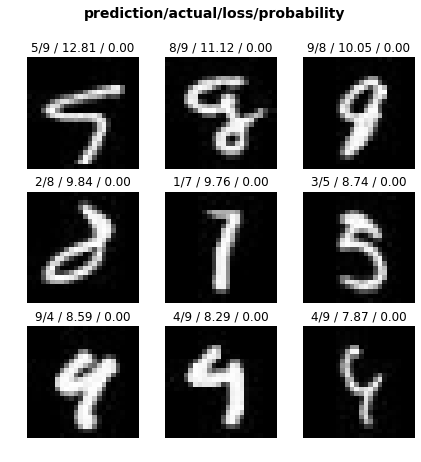

In [35]:
interp.plot_top_losses(9,figsize=(7,7))

These are the images which had the highest loss, that is the biggest difference between the probability of being corect and actually being correct. Looking at these images, it is actually pretty difficult to distinguish some of these images, so we can be sure that the CNN is actually working pretty well, if it knows these are difficult to differentiate.

Now for prediction:

In [38]:
class_score,y=learn.get_preds(DatasetType.Test)

In [40]:
probs= class_score[0].tolist()
[f"{index}: {probs[index]}" for index in range(len(probs))]

['0: 1.5195071763340895e-12',
 '1: 1.0',
 '2: 1.1358172041786574e-10',
 '3: 8.502465398407821e-11',
 '4: 1.0075866807568445e-09',
 '5: 7.13131276253165e-10',
 '6: 2.161279835655172e-11',
 '7: 1.8498513831843866e-10',
 '8: 3.5617325755410434e-10',
 '9: 1.9515083993226767e-10']

These are the probabilities that the image is any of these numbers. But we don't want that. We only want the highest probability:

In [41]:
class_score=np.argmax(class_score,axis=1)

In [42]:
class_score[0].item()

1

Now, creating the submission file based on the example given (which should contain ImageId and Label):

In [45]:
samplesub=pd.read_csv(inputs/"sample_submission.csv")
samplesub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [52]:
ImageId = [os.path.splitext(path)[0] for path in os.listdir(te)]
ImageId = [int(path) for path in ImageId]
ImageId = [ID+1 for ID in ImageId]
ImageId[:5]

[21368, 26151, 21961, 10436, 6791]

In [53]:
subs=pd.DataFrame({"ImageId":ImageId,"Label":class_score})

In [54]:
subs.to_csv("submission.csv",index=False)
subs.head(3)

,ImageId,Label
0,21368,1
1,26151,0
2,21961,8


And that's it. Simple.
This model, submitted, gives around 98.5% accuracy, which is very high for such a simple model. Using only lesson 1, this is a good start. 